Сулимов А., Трофимов И., Рылова А.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp, quad
from scipy import odr
from joblib import Parallel, delayed
from functools import partial
import matplotlib.pyplot as plt


In [2]:
# Ваши функции funct_Ix и funct_Iy для интегралов
def funct_Ix(phi, mx, r, d):
    return np.sin(phi) * np.exp(-d / np.cos(phi)) * np.sin(r * mx * np.tan(phi))

def funct_Iy(phi, mx, r, d):
    return np.cos(phi) * np.exp(-d / np.cos(phi)) * np.cos(r * mx * np.tan(phi))

# Функция для вычисления критического тока Jc0
def jc0(d):
    result = quad(lambda phi: np.cos(phi) * np.exp(-d / np.cos(phi)), -np.pi / 2, np.pi / 2)
    return result

# Вычисление интегралов Ix и Iy для разных mx
def compute_Ix_Iy(mx_values, r, d):
    arr_Ix = np.zeros(len(mx_values), dtype=np.float64)
    arr_Iy = np.zeros(len(mx_values), dtype=np.float64)
    for ind, mx in enumerate(mx_values):
        arr_Ix[ind], _ = quad(funct_Ix, -np.pi/2, np.pi/2, args=(mx, r, d))
        arr_Iy[ind], _ = quad(funct_Iy, -np.pi/2, np.pi/2, args=(mx, r, d))
    return arr_Ix, arr_Iy

# Построение полиномов для Ixfit и Iyfit
def build_polynomials(mx_values, Ix_values, Iy_values):
    poly_model_Ix = odr.polynomial(9)
    poly_model_Iy = odr.polynomial(8)

    # Для Ix
    data_Ix = odr.Data(mx_values, Ix_values)
    odr_obj_Ix = odr.ODR(data_Ix, poly_model_Ix)
    output_Ix = odr_obj_Ix.run()
    Ixfit = np.poly1d(output_Ix.beta[::-1])

    # Для Iy
    data_Iy = odr.Data(mx_values, Iy_values)
    odr_obj_Iy = odr.ODR(data_Iy, poly_model_Iy)
    output_Iy = odr_obj_Iy.run()
    Iyfit = np.poly1d(output_Iy.beta[::-1])

    return Ixfit, Iyfit

# Решение системы уравнений
def my_sfs(t, S, G, r, alpha, wF, d, V, J0, Ixfit, Iyfit):
    mx, my, mz = S

    Jx = Ixfit(mx)
    Jy = Iyfit(mx)

    Hx = (G * r * Jx / J0) * (1 - np.cos(V * t - r * my))
    Hy = (G * r * Jy / J0) * np.sin(V * t - r * my) + my
    Hz = 0

    H = [Hx, Hy, Hz]
    M = [mx, my, mz]

    m2 = np.dot(M, M)
    HdM = np.dot(H, M)

    ksi = -wF / (1 + alpha * alpha * m2)

    dmx = ksi * ((my * Hz - mz * Hy) + alpha * (mx * HdM - Hx * m2))
    dmy = ksi * ((mz * Hx - mx * Hz) + alpha * (my * HdM - Hy * m2))
    dmz = ksi * ((mx * Hy - my * Hx) + alpha * (mz * HdM - Hz * m2))

    return [dmx, dmy, dmz]

# Решение системы для одного значения G
def solve_for_G(G, r, alpha, wF, d, V, J0, Ixfit, Iyfit, t0, tf, s0):
    f = partial(my_sfs, G=G, r=r, alpha=alpha, wF=wF, d=d, V=V, J0=J0, Ixfit=Ixfit, Iyfit=Iyfit)
    t_eval = np.linspace(t0, tf, 1000)  # Интервал времени для решения
    sol = solve_ivp(f, [t0, tf], s0, t_eval=t_eval, method='BDF', rtol=1e-8, atol=1e-8)
    return sol.t, sol.y

# Поиск времени стабилизации ts
def find_stabilization_time(sol_t, sol_y, tol=1e-6):
    mx = sol_y[0, :]
    diff = np.abs(np.gradient(mx, sol_t))
    ts_index = np.argmax(diff < tol)
    return sol_t[ts_index] if ts_index > 0 else sol_t[-1]

# Усреднение значений mx, my, mz в интервале [ts, tf]
def average_solution(sol_t, sol_y, ts, tmax):
    indices = (sol_t >= ts) & (sol_t <= tmax)
    mx_avg = np.mean(sol_y[0, indices])
    my_avg = np.mean(sol_y[1, indices])
    mz_avg = np.mean(sol_y[2, indices])
    return mx_avg, my_avg, mz_avg

# Параллельное выполнение для различных G
def process_G_values(G_values, r, alpha, wF, d, V, J0, Ixfit, Iyfit, t0, tf, s0):
    results = Parallel(n_jobs=-1)(delayed(solve_for_G)(G, r, alpha, wF, d, V, J0, Ixfit, Iyfit, t0, tf, s0) for G in G_values)
    
    avg_results = []
    for sol_t, sol_y in results:
        ts = find_stabilization_time(sol_t, sol_y)
        mx_avg, my_avg, mz_avg = average_solution(sol_t, sol_y, ts, tf)
        avg_results.append((mx_avg, my_avg, mz_avg))
    
    return avg_results



In [3]:
%%time
# Инициализация параметров
Npoint = 1000
arr_mx = np.linspace(-1, 1, Npoint, endpoint=True)

r = 0.5
alpha = 0.01
wF = 1
d = 0.3
V = 5
t0 = 0
tf = 1500
mx0 = -0.5
mz0 = 0
my0 = np.sqrt(1 - mx0**2 - mz0**2)
s0 = np.array([mx0, my0, mz0])

# Рассчет Jc0
J0 = jc0(d)[0]

# Вычисление Ix и Iy
arr_Ix, arr_Iy = compute_Ix_Iy(arr_mx, r, d)

# Построение полиномов для Ixfit и Iyfit
Ixfit, Iyfit = build_polynomials(arr_mx, arr_Ix, arr_Iy)

CPU times: user 1.85 s, sys: 7.92 ms, total: 1.85 s
Wall time: 1.85 s


In [4]:
%%time
# Значения G
G_values = np.linspace(0.1, 10, 200)  # Диапазон значений G

# Запуск расчета для всех значений G
avg_results = process_G_values(G_values, r, alpha, wF, d, V, J0, Ixfit, Iyfit, t0, tf, s0)

CPU times: user 525 ms, sys: 385 ms, total: 910 ms
Wall time: 4min 19s


In [5]:
# Вывод результатов
for G, (mx_avg, my_avg, mz_avg) in zip(G_values, avg_results):
    print(f"G = {G:.2f}: <avg_mx> = {mx_avg:.4f}, <my_avg> = {my_avg:.4f}, <avg_mz> = {mz_avg:.4f}")

G = 0.10: <avg_mx> = -0.0000, <my_avg> = 1.0000, <avg_mz> = 0.0000
G = 0.15: <avg_mx> = -0.0000, <my_avg> = 1.0000, <avg_mz> = 0.0000
G = 0.20: <avg_mx> = 0.0000, <my_avg> = 1.0000, <avg_mz> = -0.0000
G = 0.25: <avg_mx> = -0.0000, <my_avg> = 1.0000, <avg_mz> = 0.0000
G = 0.30: <avg_mx> = 0.0000, <my_avg> = 1.0000, <avg_mz> = -0.0000
G = 0.35: <avg_mx> = -0.0000, <my_avg> = 1.0000, <avg_mz> = 0.0000
G = 0.40: <avg_mx> = -0.0000, <my_avg> = 1.0000, <avg_mz> = 0.0000
G = 0.45: <avg_mx> = -0.0000, <my_avg> = 1.0000, <avg_mz> = 0.0000
G = 0.50: <avg_mx> = 0.0000, <my_avg> = 1.0000, <avg_mz> = -0.0000
G = 0.55: <avg_mx> = -0.0000, <my_avg> = 1.0000, <avg_mz> = 0.0000
G = 0.60: <avg_mx> = -0.0000, <my_avg> = 1.0000, <avg_mz> = 0.0000
G = 0.65: <avg_mx> = -0.0000, <my_avg> = 1.0000, <avg_mz> = 0.0000
G = 0.70: <avg_mx> = -0.0000, <my_avg> = 1.0000, <avg_mz> = 0.0000
G = 0.75: <avg_mx> = 0.0000, <my_avg> = 1.0000, <avg_mz> = -0.0000
G = 0.80: <avg_mx> = -0.0000, <my_avg> = 1.0000, <avg_mz> = 0.

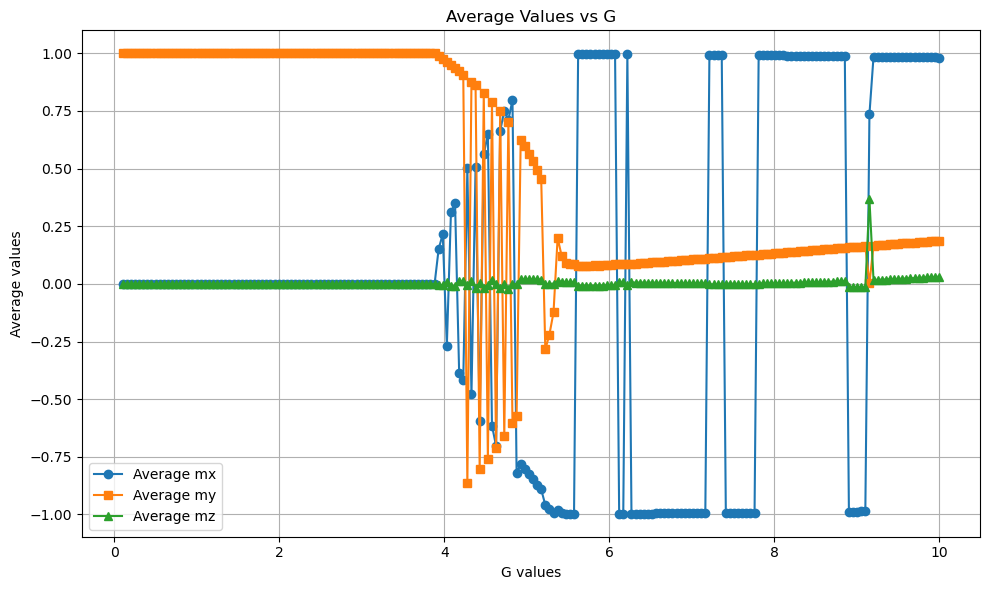

In [6]:
def plot_avg_values(G_values, avg_results):
    # Извлечение средних значений для каждой линии
    mx_avg = [result[0] for result in avg_results]
    my_avg = [result[1] for result in avg_results]
    mz_avg = [result[2] for result in avg_results]

    # Построение графиков
    plt.figure(figsize=(10, 6))
    plt.plot(G_values, mx_avg, label='Average mx', marker='o')
    plt.plot(G_values, my_avg, label='Average my', marker='s')
    plt.plot(G_values, mz_avg, label='Average mz', marker='^')

    # Настройка графика
    plt.title('Average Values vs G')
    plt.xlabel('G values')
    plt.ylabel('Average values')
    plt.legend()
    plt.grid()
    plt.tight_layout()

    # Отображение графика
    plt.show()
    
plot_avg_values(G_values, avg_results)